## Importing Libraries

In [ ]:
#For Downloading the dataset on colab

#!wget https://datasets.aicrowd.com/default/aicrowd-public-datasets/food-recognition-challenge/v0.4/test_images-v0.4.tar.gz
#!wget https://datasets.aicrowd.com/default/aicrowd-public-datasets/food-recognition-challenge/v0.4/train-v0.4.tar.gz

In [ ]:
#!unzip train-v0.4.tar.gz

In [ ]:
#Extract dataset from the tar files
#!for f in *.tar.gz; do tar xf "$f"; done

In [ ]:
#%pip install git+https://github.com/tensorflow/examples

In [ ]:
%pip install git+https://github.com/AIcrowd/coco.git#subdirectory=PythonAPI

  Cloning https://github.com/AIcrowd/coco.git to /tmp/pip-req-build-2cqnylx8
  Running command git clone -q https://github.com/AIcrowd/coco.git /tmp/pip-req-build-2cqnylx8
  Created wheel for pycocotools: filename=pycocotools-2.0-cp37-cp37m-linux_x86_64.whl size=263868 sha256=6ba8c1820096d715eedef36c0ea9d437d0908249cd1ca7f331927fc5c0522a87
  Stored in directory: /tmp/pip-ephem-wheel-cache-22ck27ig/wheels/ab/90/04/967e938726d585d7f0cdf0522611965b7e138f6cd9a6937b35
Successfully built pycocotools
  Found existing installation: pycocotools 2.0.2
    Uninstalling pycocotools-2.0.2:
      Successfully uninstalled pycocotools-2.0.2


In [ ]:
import tensorflow as tf
from keras import backend as K

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPool2D, UpSampling2D, Concatenate
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam

from google.colab import drive

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import numpy as np

import random

import cv2

import skimage.io as io

from pycocotools import mask as cocomask

import os

drive.mount('/content/drive')

Mounted at /content/drive


## Loading the data

In [ ]:
from pycocotools.coco import COCO

#Loading the coco annotations
folder_loc = "/content/drive/MyDrive/Food_recognition"

coco_train = COCO(folder_loc + '/train/annotations.json')
coco_val = COCO(folder_loc + '/val/annotations.json')


loading annotations into memory...
Done (t=3.30s)
creating index...
index created!
loading annotations into memory...
Done (t=0.81s)
creating index...
index created!


## Exploring the data

In [ ]:
def plot_image(image_id):
    #read the image
    img = coco_train.loadImgs(image_id)[0]
    image = mpimg.imread(folder_loc + '/train/images/' + img['file_name'])
    
    #display image
    img_plot = plt.imshow(image)
    
    #loading image id
    annotations = coco_train.loadAnns(coco_train.getAnnIds(imgIds=image_id))

    for i in range(len(annotations)):
        #different color for different annotations
        colors = ['b', 'c', 'r', 'g', 'm', 'y', 'k'][i]
        ann = annotations[i]

        #plotting segmentation
        for seg in ann['segmentation']:
            plt.fill(seg[0::2], seg[1::2], colors, alpha=0.4)
            plt.fill(seg[0::2], seg[1::2], colors, alpha=0.8)
  
    #show results
    plt.show()

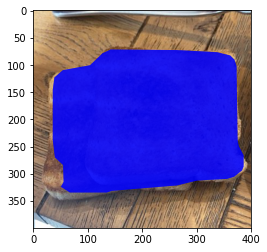

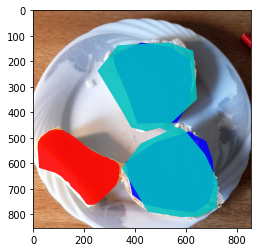

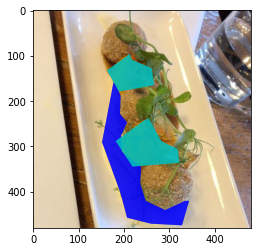

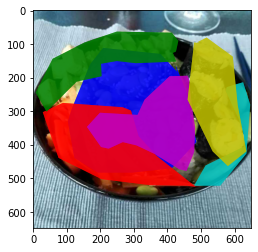

In [ ]:
#Plotting a few random images

np.random.seed(100)
img_num = []
rand = np.random.randint(0, len(coco_train.getImgIds()), 4)
for i in rand:
    img_num.append(coco_train.getImgIds()[i])
for ids in img_num:
    plot_image(ids)

## Loading and cleaning the data

Sorting the category ids by popularity

In [ ]:
def get_ordered_ids():
    catIds_raw = coco_train.getCatIds()
    catIds = []
    for cat in catIds_raw:
          catIds.append([len(coco_train.getImgIds(catIds=cat)), cat])
    catIds.sort()
    cat_ids = [cat_num[1] for cat_num in catIds ]
    return cat_ids

In [ ]:
# display COCO categories
categories = coco_train.loadCats(get_ordered_ids())
classes=[cat['name'] for cat in categories]
number_of_classes = len(classes)
print('COCO categories: ', number_of_classes)
print(classes)

COCO categories:  273
['veggie-burger', 'falafel-balls', 'bread-pita', 'rusk-wholemeal', 'frying-sausage', 'applesauce-unsweetened-canned', 'hazelnut', 'tea-peppermint', 'sauce-mushroom', 'sauce-soya', 'greek-yaourt-yahourt-yogourt-ou-yoghourt', 'green-bean-steamed-without-addition-of-salt', 'alfa-sprouts', 'beans-kidney', 'dates', 'focaccia', 'chocolate-cookies', 'tea-verveine', 'beef-sirloin-steak', 'beef-cut-into-stripes-only-meat', 'fruit-coulis', 'pizza-with-ham-baked', 'vegetable-mix-peas-and-carrots', 'cream', 'rice-whole-grain', 'artichoke', 'sesame-seeds', 'juice-apple', 'greek-salad', 'plums', 'dried-raisins', 'kefir-drink', 'veal-sausage', 'meat-terrine-pata-c', 'ice-tea', 'ham-croissant', 'soup-of-lentils-dahl-dhal', 'beetroot-raw', 'brioche', 'butter-spread-puree-almond', 'crunch-ma1-4esli', 'brownie', 'corn-crisps', 'mixed-seeds', 'bread-rye', 'bacon-cooking', 'pumpkin', 'flakes-oat', 'bread-5-grain', 'bread-fruit', 'rosti', 'pasta-noodles', 'hazelnut-chocolate-spread-nut

## Defining functions to manage the dataset

Function to filter the dataset

In [ ]:
def filterDataset(folder, mode, classes=None):    
    # initialize COCO api for instance annotations
    annFile = '{}/{}/annotations.json'.format(folder, mode)
    coco = COCO(annFile)
    
    images = []

    if classes!=None:
        # iterate for each individual class in the list
        for className in classes:
            # get all images containing given categories
            catIds = coco.getCatIds(catNms=className)
            imgIds = coco.getImgIds(catIds=catIds)
            images += coco.loadImgs(imgIds)
    
    else:
      imgIds = coco.getImgIds()
      images = coco.loadImgs(imgIds)
    
    # Now, filter out the repeated images
    unique_images = []
    for i in range(len(images)):
        if images[i] not in unique_images:
            unique_images.append(images[i])
            
    random.shuffle(unique_images)
    dataset_size = len(unique_images)
    
    return unique_images, dataset_size, coco

Functions to create the masks

In [ ]:
def getClassName(classID, cats):
    for i in range(len(cats)):
        if cats[i]['id']==classID:
            return cats[i]['name']
    return "None"

def getImage(imageObj, img_folder, input_image_size):
    # Read and normalize an image
    train_img = io.imread(img_folder + '/' + imageObj['file_name'])/255.0
    # Resize
    train_img = cv2.resize(train_img, input_image_size)
    if (len(train_img.shape)==3 and train_img.shape[2]==3): # If it is a RGB 3 channel image
        return train_img
    else: # To handle a black and white image, increase dimensions to 3
        stacked_img = np.stack((train_img,)*3, axis=-1)
        return stacked_img
    
def getNormalMask(imageObj, classes, coco, catIds, input_image_size):
    annIds = coco.getAnnIds(imageObj['id'], catIds=catIds, iscrowd=None)
    anns = coco.loadAnns(annIds)
    cats = coco.loadCats(catIds)
    train_mask = np.zeros(input_image_size)
    for a in range(len(anns)):
        className = getClassName(anns[a]['category_id'], cats)
        #Assign to the pixel the value of the class
        pixel_value = classes.index(className)+1
        #The annToMask method returns a binary mask. 
        #Multipling the mask of that class by the pixel_value we assign that value to each of the pixels  
        new_mask = cv2.resize(coco.annToMask(anns[a])*pixel_value, input_image_size)
        #With np.maximum we join all the masks of different classes into a single one
        #The classes are sorted by popularity in descending order, so the mask of the most popular classes will prevail on the others
        train_mask = np.maximum(new_mask, train_mask)

    # Add extra dimension for parity with train_img size [X * X * 3]
    train_mask = train_mask.reshape(input_image_size[0], input_image_size[1], 1)
    return train_mask  

def getBinaryMask(imageObj, classes, coco, catIds, input_image_size):
    annIds = coco.getAnnIds(imageObj['id'], catIds=catIds, iscrowd=None)
    anns = coco.loadAnns(annIds)
    cats = coco.loadCats(catIds)
    n_classes = len(classes) + 1
    train_mask = np.zeros((input_image_size[0], input_image_size[1], n_classes))
    for i in range(len(anns)):
        #Get the index of the class
        className = getClassName(anns[i]['category_id'], cats)
        class_index = classes.index(className) + 1

        #If the index of the class is equal to the index iterating through the annotation add the
        #binary mask to the array
        
        new_mask = cv2.resize(coco.annToMask(anns[i]), input_image_size)
        #Threshold because resizing may cause extraneous values
        new_mask[new_mask >= 0.5] = 1
        new_mask[new_mask < 0.5] = 0
        train_mask[:,:,class_index] = new_mask

    #Adding background mask into the training mask in position 0
    food_mask = np.argmax(train_mask, axis=2)
    background_mask = (np.logical_not(food_mask)).astype(int)
    train_mask[:,:,0] = background_mask
    
    return train_mask

Data generators

In [ ]:
def dataGeneratorCoco(images, classes, coco, folder, 
                      input_image_size, batch_size, mode, mask_type):
    
    img_folder = '{}/{}/images'.format(folder, mode)
    dataset_size = len(images)
    #catIds = get_category_ids()
    catIds = coco.getCatIds(catNms=classes)
    n_classes = len(classes) + 1
    
    c = 0
    while(True):
        img = np.zeros((batch_size, input_image_size[0], input_image_size[1], 3)).astype('float')
        #mask = np.zeros((batch_size, input_image_size[0], input_image_size[1], 1)).astype('float')
        mask = np.zeros((batch_size, input_image_size[0], input_image_size[1], n_classes)).astype('float')

        for i in range(c, c+batch_size): #initially from 0 to batch_size, when c = 0
            imageObj = images[i]
            
            ### Retrieve Image ###
            train_img = getImage(imageObj, img_folder, input_image_size)
            
            ### Create Mask ###
            if mask_type=="binary":
                train_mask = getBinaryMask(imageObj, classes, coco, catIds, input_image_size)
            
            elif mask_type=="normal":
                train_mask = getNormalMask(imageObj, classes, coco, catIds, input_image_size)                
            
            # Add to respective batch sized arrays
            img[i-c] = train_img
            mask[i-c] = train_mask
            
        c+=batch_size
        if(c + batch_size >= dataset_size):
            c=0
            random.shuffle(images)
        yield img, mask

In [ ]:
def visualizeGenerator(gen):
    # Iterate the generator to get image and mask batches
    img, mask = next(gen)

    n_classes = len(classes) + 1
    fig = plt.figure(figsize=(20, 10))
    outerGrid = gridspec.GridSpec(1, 2, wspace=0.1, hspace=0.1)
   
    for i in range(2):        
        innerGrid = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=outerGrid[i], wspace=0.05, hspace=0.05)
        for j in range(4):
            ax = plt.Subplot(fig, innerGrid[j])
            if(i==1):
                ax.imshow(img[j]);
            else:
                final_mask = np.zeros((input_image_size[0], input_image_size[1]))
                for i in range(1, n_classes):
                    color = i + 1
                    new_mask = mask[j][:,:,i]*color
                    final_mask = np.maximum(new_mask, final_mask)
                ax.imshow(final_mask);
            ax.axis('off')
            fig.add_subplot(ax)
    plt.show()

## Filtering the dataset and defining the generators

In [ ]:
classes = ['pasta-spaghetti','tomato-sauce', 'apple', 'bread-white', 'water']
#classes = ['water']
#classes = ['apple', 'tea-green', 'white-coffee-with-caffeine', 'tea-black', 'mixed-salad-chopped-without-sauce', 'cheese', 'tomato-sauce', 'pasta-spaghetti', 'carrot', 'onion', 'beef-cut-into-stripes-only-meat', 'rice-noodles-vermicelli', 'salad-leaf-salad-green', 'bread-grain', 'espresso-with-caffeine', 'banana', 'mixed-vegetables', 'bread-wholemeal', 'savoury-puff-pastry', 'wine-white', 'dried-meat', 'fresh-cheese', 'red-radish', 'hard-cheese', 'ham-raw', 'bread-fruit', 'oil-vinegar-salad-dressing', 'tomato', 'cauliflower', 'potato-gnocchi', 'wine-red', 'sauce-cream', 'pasta-linguini-parpadelle-tagliatelle', 'french-beans', 'almonds', 'dark-chocolate', 'mandarine', 'semi-hard-cheese', 'croissant', 'sushi', 'berries', 'biscuits', 'thickened-cream-35', 'corn', 'celeriac', 'alfa-sprouts', 'chickpeas', 'leaf-spinach', 'rice', 'chocolate-cookies', 'pineapple', 'tart', 'coffee-with-caffeine', 'focaccia', 'pizza-with-vegetables-baked', 'soup-vegetable', 'bread-toast', 'potatoes-steamed', 'spaetzle', 'frying-sausage', 'lasagne-meat-prepared', 'boisson-au-glucose-50g', 'ma1-4esli', 'peanut-butter', 'chips-french-fries', 'mushroom', 'ratatouille', 'veggie-burger', 'country-fries', 'yaourt-yahourt-yogourt-ou-yoghourt-natural', 'hummus', 'fish', 'beer', 'peanut', 'pizza-margherita-baked', 'pickle', 'ham-cooked', 'cake-chocolate', 'bread-french-white-flour', 'sauce-mushroom', 'rice-basmati', 'soup-of-lentils-dahl-dhal', 'pumpkin', 'witloof-chicory', 'vegetable-au-gratin-baked', 'balsamic-salad-dressing', 'pasta-penne', 'tea-peppermint', 'soup-pumpkin', 'quiche-with-cheese-baked-with-puff-pastry', 'mango', 'green-bean-steamed-without-addition-of-salt', 'cucumber', 'bread-half-white', 'pasta', 'beef-filet', 'pasta-twist', 'pasta-wholemeal', 'walnut', 'soft-cheese', 'salmon-smoked', 'sweet-pepper', 'sauce-soya', 'chicken-breast', 'rice-whole-grain', 'bread-nut', 'green-olives', 'roll-of-half-white-or-white-flour-with-large-void', 'parmesan', 'cappuccino', 'flakes-oat', 'mayonnaise']
images_train, dataset_size_train, coco_train = filterDataset(folder_loc,'train',classes)

loading annotations into memory...
Done (t=1.78s)
creating index...
index created!


In [ ]:
images_val, dataset_size_val, coco_val = filterDataset(folder_loc,'val',classes)

loading annotations into memory...
Done (t=0.08s)
creating index...
index created!


In [ ]:
print("The training set size is:", dataset_size_train)
print("The validation set size is:", dataset_size_val)

The training set size is: 4091
The validation set size is: 220


In [ ]:
batch_size = 16
input_image_size = (256,256)
mask_type = 'binary'

train_gen = dataGeneratorCoco(images_train, classes, coco_train, folder_loc,
                            input_image_size, batch_size, 'train', mask_type)

val_gen = dataGeneratorCoco(images_val, classes, coco_val, folder_loc,
                            input_image_size, batch_size, 'val', mask_type)

## Testing if get_binary_mask function works

Class 0 mask: 


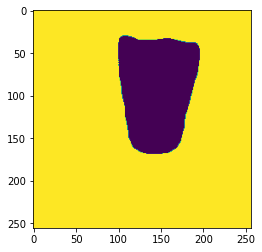

Class 1 mask: 


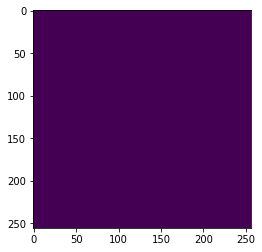

Class 2 mask: 


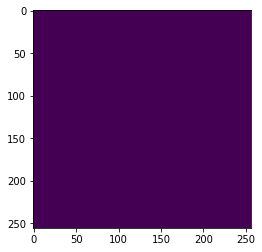

Class 3 mask: 


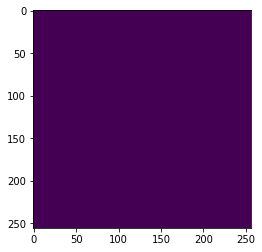

Class 4 mask: 


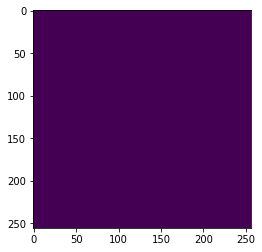

Class 5 mask: 


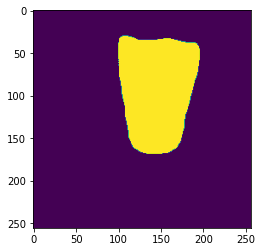

In [ ]:
catIds = coco_train.getCatIds(catNms=classes)
mask = getBinaryMask(images_train[5], classes, coco_train, catIds, input_image_size)

n_classes = len(classes) + 1
final_mask = np.zeros((input_image_size[0], input_image_size[1]))
for i in range(n_classes):
    color = i + 1
    new_mask = mask[:,:,i]*color
    plt.imshow(new_mask)
    print("Class {} mask: ".format(i))
    plt.show()
    #final_mask = np.maximum(new_mask, final_mask)

#plt.imshow(final_mask)

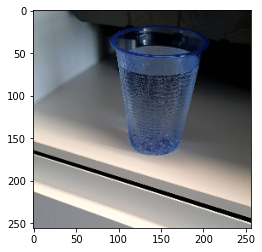

In [ ]:
img_folder = '{}/{}/images'.format(folder_loc, 'train')
train_img = getImage(images_train[5], img_folder, input_image_size)
plt.imshow(train_img)

## Visualize the masks


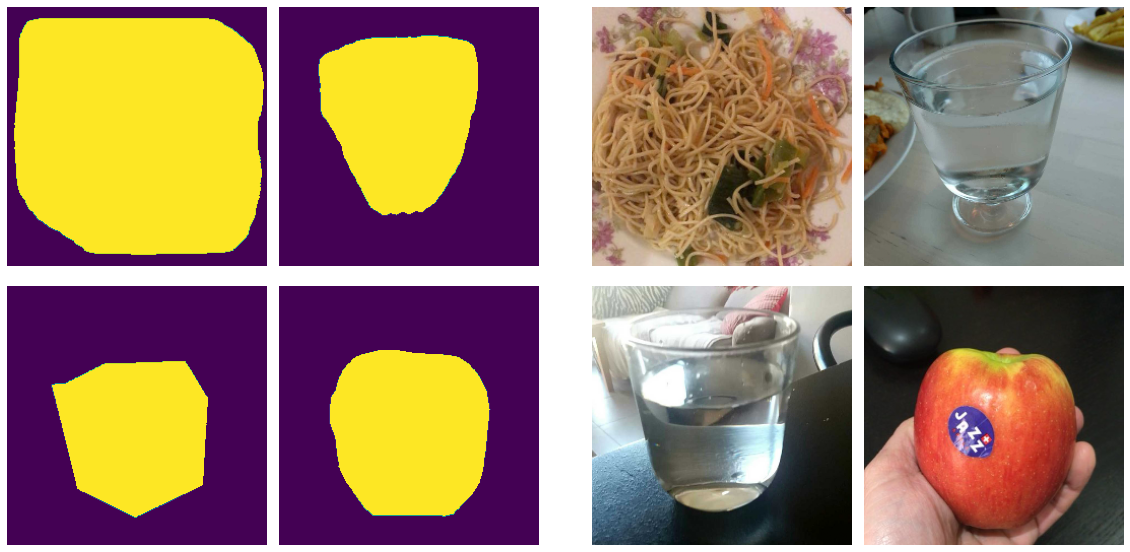

In [ ]:
visualizeGenerator(train_gen)

In [ ]:
img, mask = next(train_gen)
print("The shape of the image batch is: ", img.shape)
print("The shape of the mask batch is: ", img.shape)

The shape of the image batch is:  (16, 256, 256, 3)
The shape of the mask batch is:  (16, 256, 256, 3)


## Data augmentation

In [ ]:
def augmentationsGenerator(gen, augGeneratorArgs, seed=None):
    # Initialize the image data generator with args provided
    image_gen = ImageDataGenerator(**augGeneratorArgs)
    
    # Remove the brightness argument for the mask. Spatial arguments similar to image.
    augGeneratorArgs_mask = augGeneratorArgs.copy()
    _ = augGeneratorArgs_mask.pop('brightness_range', None)
    # Initialize the mask data generator with modified args
    mask_gen = ImageDataGenerator(**augGeneratorArgs_mask)
    
    np.random.seed(seed if seed is not None else np.random.choice(range(9999)))

    n_classes = len(classes)

    for img, mask in gen:

        seed = np.random.choice(range(9999))
        # keep the seeds syncronized otherwise the augmentation of the images 
        # will end up different from the augmentation of the masks
        g_x = image_gen.flow(255*img, 
                             batch_size = img.shape[0], 
                             seed = seed, 
                             shuffle=True)
        
        g_y = mask_gen.flow(mask, 
                             batch_size = mask.shape[0], 
                             seed = seed, 
                             shuffle=True)

        img_aug = next(g_x)/255.0
        
        mask_aug = next(g_y)
                   

        yield img_aug, mask_aug

In [ ]:
augGeneratorArgs = dict(featurewise_center = False, 
                        samplewise_center = False,
                        rotation_range = 5, 
                        width_shift_range = 0.01, 
                        height_shift_range = 0.01, 
                        brightness_range = (0.8,1.2),
                        shear_range = 0.01,
                        zoom_range = [1, 1.25],  
                        horizontal_flip = True, 
                        vertical_flip = False,
                        fill_mode = 'reflect',
                        data_format = 'channels_last')

train_gen_aug = augmentationsGenerator(train_gen, augGeneratorArgs)

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/numpy_array_iterator.py:136: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (16, 256, 256, 6) (6 channels).
  str(self.x.shape[channels_axis]) + ' channels).')


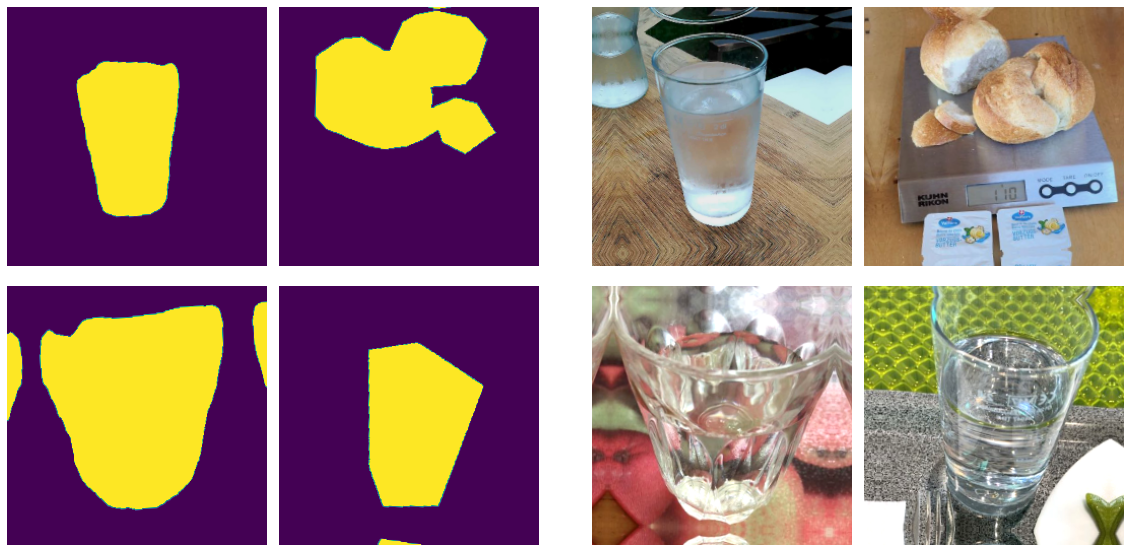

In [ ]:
visualizeGenerator(train_gen_aug)

## Building model architecture

Defining a U-net model.

Create a function that returns the model

In [ ]:
# Build U-Net model
dropout=0.2
hn = 'he_normal'
def unet(shape, num_classes):
    
    inputs = Input(shape)
    
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = hn)(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = hn)(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = hn)(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = hn)(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = hn)(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = hn)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = hn)(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = hn)(conv4)
    drop4 = Dropout(dropout)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = hn)(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = hn)(conv5)
    drop5 = Dropout(dropout)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = hn)(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = hn)(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = hn)(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = hn)(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = hn)(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = hn)(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = hn)(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = hn)(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = hn)(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = hn)(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = hn)(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = hn)(conv9)
    #conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    
    conv10 = Conv2D(num_classes, (1,1), activation = 'softmax')(conv9)
    
    model = Model(inputs = inputs, outputs = conv10)

    return model 

In [ ]:
number_of_classes=len(classes) + 1
model = unet((input_image_size[0], input_image_size[1], 3), number_of_classes)


In [ ]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_48 (Conv2D)              (None, 256, 256, 64) 1792        input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_49 (Conv2D)              (None, 256, 256, 64) 36928       conv2d_48[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_8 (MaxPooling2D)  (None, 128, 128, 64) 0           conv2d_49[0][0]                  
____________________________________________________________________________________________

## Defining custom losses and metrics

Defining the Intersection over union metric

In [ ]:
#This works with a Flat mask where each pixel has a categorical class 

class MeanIoU(tf.keras.metrics.MeanIoU):
  def __init__(self,
               y_true=None,
               y_pred=None,
               num_classes=None,
               name=None,
               dtype=None):
    super(MeanIoU, self).__init__(num_classes = num_classes,name=name, dtype=dtype)

  def update_state(self, y_true, y_pred, sample_weight=None):
    y_pred = tf.math.argmax(y_pred, axis=-1)
    return super().update_state(y_true, y_pred, sample_weight)

## Training the model 

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
n_epochs = 10

steps_per_epoch = dataset_size_train // batch_size
validation_steps = dataset_size_val // batch_size


#lossFn = weightedLoss(tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),class_weights)
#lossFn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
#lossFn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
lossFn = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# Compile model
model.compile(loss = lossFn, optimizer = Adam(lr = 1e-4), metrics=['accuracy', tf.metrics.MeanIoU(num_classes=number_of_classes)])


#checkpoint_filepath = '/tmp/checkpoint'

#Define the callbacks
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    #ModelCheckpoint(filepath=checkpoint_filepath, verbose=1, save_best_only=True, save_weights_only=True)
]

# Start the training process
history = model.fit(x = train_gen_aug,
                validation_data = val_gen,
                steps_per_epoch = steps_per_epoch,
                validation_steps = validation_steps,
                epochs = n_epochs,  
                callbacks = callbacks,
                verbose = True)

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/numpy_array_iterator.py:136: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (16, 256, 256, 6) (6 channels).
  str(self.x.shape[channels_axis]) + ' channels).')


Epoch 1/10
255/255 [==============================] - 320s 1s/step - loss: 0.1691 - accuracy: 0.7932 - mean_io_u: 0.4298 - val_loss: 0.1866 - val_accuracy: 0.7557 - val_mean_io_u: 0.4176
Epoch 2/10
255/255 [==============================] - 319s 1s/step - loss: 0.1545 - accuracy: 0.8111 - mean_io_u: 0.4295 - val_loss: 0.1696 - val_accuracy: 0.7828 - val_mean_io_u: 0.4168
Epoch 3/10
255/255 [==============================] - 318s 1s/step - loss: 0.1422 - accuracy: 0.8260 - mean_io_u: 0.4271 - val_loss: 0.1518 - val_accuracy: 0.8053 - val_mean_io_u: 0.4178
Epoch 4/10
255/255 [==============================] - 321s 1s/step - loss: 0.1367 - accuracy: 0.8334 - mean_io_u: 0.4299 - val_loss: 0.1573 - val_accuracy: 0.8058 - val_mean_io_u: 0.4230
Epoch 5/10
255/255 [==============================] - 322s 1s/step - loss: 0.1289 - accuracy: 0.8424 - mean_io_u: 0.4280 - val_loss: 0.1386 - val_accuracy: 0.8276 - val_mean_io_u: 0.4251
Epoch 6/10
255/255 [==============================] - 322s 1s/ste

## Plot loss and accuracy graphs

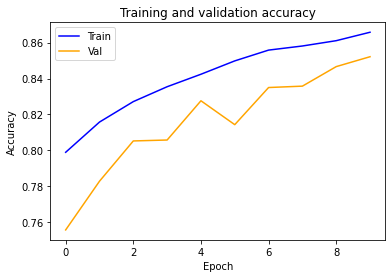

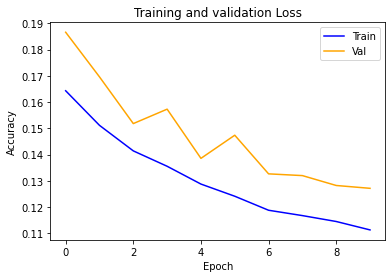

In [ ]:
def plot_history(history):
    
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    #get the numbero of epochs
    epochs = range(len(acc))
    
    plt.title("Training and validation accuracy")
    plt.plot(epochs, acc, color='blue', label='Train')
    plt.plot(epochs, val_acc, color='orange', label='Val')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    _ = plt.figure()

    plt.title("Training and validation Loss")
    plt.plot(epochs, loss, color='blue', label='Train')
    plt.plot(epochs, val_loss, color='orange', label='Val')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
plot_history(history)

## Display model predictions

In [ ]:
def display(display_list):
  plt.figure(figsize=(10, 10))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

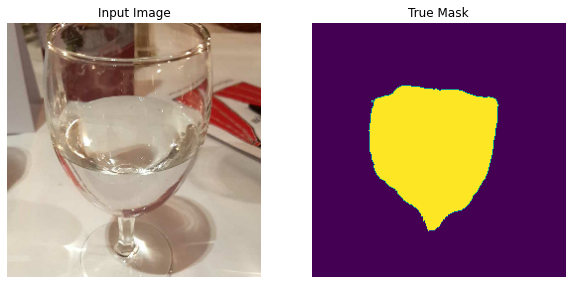

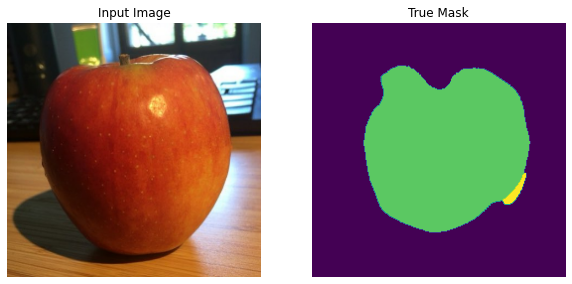

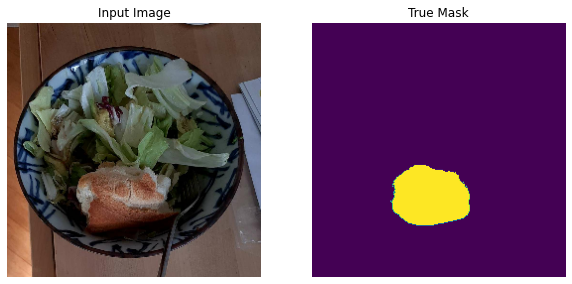

In [ ]:
#Plotting a few random images of the validations set

#np.random.seed(100)

val_images_ids = []
for className in classes:
    # get all images containing given categories
    catIds = coco_val.getCatIds(catNms=className)
    imgIds = coco_val.getImgIds(catIds=catIds)
    for i in imgIds:
        val_images_ids.append(i)

num_image_to_plot = 3
rand = np.random.randint(0, len(images_val), num_image_to_plot)

X = np.zeros((num_image_to_plot, input_image_size[0], input_image_size[1], 3))

j = 0
for i in rand:
  img = coco_val.loadImgs(val_images_ids[i])[0]
  image = tf.io.read_file(folder_loc + '/val/images/' + img['file_name'])
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.resize(image, input_image_size)

  X[j] = image
  X[j] = X[j]/255.0

  j+=1

for i in range(len(X)):
  pred_mask = model.predict(X[i].reshape(1, input_image_size[0], input_image_size[1], 3))
  display([X[i], create_mask(pred_mask)])